In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
import pandas as pd
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image
import random
import csv
from ast import literal_eval
plt.style.use('seaborn-whitegrid')
import sys
from matplotlib import animation
np.set_printoptions(threshold = sys.maxsize)
from matplotlib.animation import FFMpegWriter
from tqdm import tqdm

/tmp/ipykernel_6860/1721827006.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:

# ensure transforms are inverses
# Functions to map between cartesian coordinates and array indexes
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j


def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)

def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    direction = np.sign(np.cross(u, v))
    if direction == 0 and np.dot(u, v) < 0:
        direction = 1
    return direction


# We don't use this elsewhere, but you might find it useful."""
def get_angle(u, v):
    """Returns the angle (in degrees) from u to v."""
    return np.degrees(np.math.atan2(
        np.cross(u, v),
        np.dot(u, v),
    ))

# compress a path between two points
def compress_path(path):
    r = [[] for _ in range(8)]
    for p in path:
        for i in range(8):
            if len(r[i]) == 0 or r[i][-1] != p[i]:
                r[i].append(p[i])
    mx = max([len(x) for x in r])

    for rr in r:
        while len(rr) < mx:
            rr.append(rr[-1])
    r = list(zip(*r))

    for i in range(len(r)):
        r[i] = list(r[i])

    return r

def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point.
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:  # Thanks @pgeiger
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    path = compress_path(path)
    return path

def plot_configuration(config, image=None, ax=None, color='0.25', **figure_args):
    def get_position(config):
        return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

    if ax is None:
        _, ax = plt.subplots(**figure_args)

    k = 2 ** (len(config) - 1) + 1
    X, Y = (np.vstack([[(0, 0)], np.asarray(config).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(config).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=color,
        width=0.005,
        zorder=10,
    )
    point = get_position(config)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
    if image is not None:
        ax.matshow(image, extent=[-k-1, k, -k-1, k])
    ax.set_xlim(-k-1, k)
    ax.set_ylim(-k-1, k)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-k, k+1))
    ax.set_yticks(np.arange(-k, k+1))
    return ax

def get_position(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)


def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


def get_square(link_length):
    link = (link_length, 0)
    coords = [link]
    for _ in range(8 * link_length - 1):
        link = rotate_link(link, direction=1)
        coords.append(link)
    return coords

def get_neighbors(config):
    nhbrs=[]
    for directions in product((-1, 0, 1), repeat=len(config)):
        currconfig = reduce(lambda x, y: rotate(x, *y), enumerate(directions), config)
        if pix_map[cartesian_to_array(*get_position(currconfig),image.shape)]==1:
            continue;
        else:    
            nhbrs += [(currconfig)]
    return list(filter(lambda c: c != config, nhbrs))


# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
def reconfiguration_cost(from_config, to_config):
    nlinks = len(from_config)
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
def step_cost(from_config, to_config, image):
    from_position = cartesian_to_array(*get_position(from_config), image.shape)
    to_position = cartesian_to_array(*get_position(to_config), image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

In [86]:
def compress_path(path):
    
    if len(path) > 2:
        
        new_path = []
        
        max_conf_dist = 1
        
        r = [[] for _ in range(len(path[0]))]
        
        for p in path:
            for i, c in enumerate(p):

                if len(r[i]) == 0 or r[i][-1] != c:
                    
                    if c not in r[i]:
                        r[i].append(c)
                    else:
                        r[i] = r[i][:r[i].index(c) + 1]
                        
                    assert r[i][-1] == c
        
        max_conf_dist = max([len(r_) for r_ in r])
        
        for i in range(max_conf_dist):
            
            new_conf = []
            
            for _, r_ in enumerate(r):
                
                if i < len(r_):
                    c_ = r_[i]
                else:
                    c_ = r_[-1]
                
                new_conf.append(c_)
            
            new_path.append(new_conf)
            
        return new_path
                               
        
    return path

In [85]:
def get_path_to_configuration(from_config, to_config):
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
    assert path[-1] == to_config
    path = compress_path(path)
    return path

In [11]:
# Compute total cost of path over image
def total_cost(path, image):
    return reduce(
        lambda cost, pair: cost + step_cost(pair[0], pair[1], image),
        zip(path[:-1], path[1:]),
        0,
    )


In [387]:
def remove_zeros(l):
    for ele in reversed(l):
        if ele==0 or ele =='':
            del l[-1]
        else:
            break
            

In [20]:
df_img = pd.read_csv('image.csv')
image = df_to_image(df_img)
assert image_to_df(image).equals(df_img) 
#pix_map = np.zeros((257,257))
#pix_map[cartesian_to_array(*get_position(config[-1]),image.shape)] = 1

In [4]:
confrun = pd.DataFrame()
for i in range(1,17):
    print(i)
    run = pd.read_csv('run'+str(i)+'.csv',header=None)
    run = pd.Series(run.values.flatten().tolist())
    confrun['Run' +str(i)]=run

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [5]:
confrun=confrun.applymap(lambda x: literal_eval(x) if pd.notnull(x) else '')

In [167]:
confpos = confrun

In [168]:
confpos = confpos.applymap(lambda x: cartesian_to_array(*get_position(x),image.shape) if x!=0 else '')

In [194]:
pm_df = pd.DataFrame(0,index=list(product(range(0,257),range(0,257))),columns=confrun.columns)

fixed_con=pd.DataFrame()

In [195]:
pm_df = pd.DataFrame(0,index=list(product(range(0,257),range(0,257))),columns=confrun.columns)
for ind,row in confpos.iterrows():
    for x in row.index:
        pm_df.at[row[x],x] =1
        
    if ind>len(pm_df):
        if (pm_df[pm_df==1].sum()==len(pm_df)).any():
            fin_img_run_num = pm_df.columns[pm_df[pm_df==1].sum()==len(pm_df)]
            fin_img_run_num = fin_img_run_num.difference(fixed_con.columns)
            for run in fin_img_run_num:
                fixed_path_seg = pd.Series(get_path_to_configuration(confrun.at[ind,run],confrun.at[0,run])[1:])
                fixed_run = pd.Series(pd.concat([confrun.loc[:ind,run],fixed_path_seg]),name=run)
                fixed_run.reset_index(inplace=True,drop=True)
                fixed_con = pd.concat([fixed_con,fixed_run],axis=1)
                

In [252]:
costs_run = pd.DataFrame()

In [212]:
fixed_con=fixed_con.fillna(0)

In [253]:
for label,cont in fixed_con.items():
    conlist= cont.values.flatten().tolist()
    remove_zeros(conlist)
    costs_run = pd.concat(
        [costs_run,pd.Series([0] + list(map(lambda x: step_cost(x[0],x[1],image), 
                zip(conlist[:-1],conlist[1:]))),name=label)],
        axis = 1)
    


In [275]:
fixed_con.to_csv('fix_runs_1-15.csv')

In [270]:
cumcosts = pd.DataFrame()

cumcosts=costs_run.expanding(1).sum()

<AxesSubplot: >

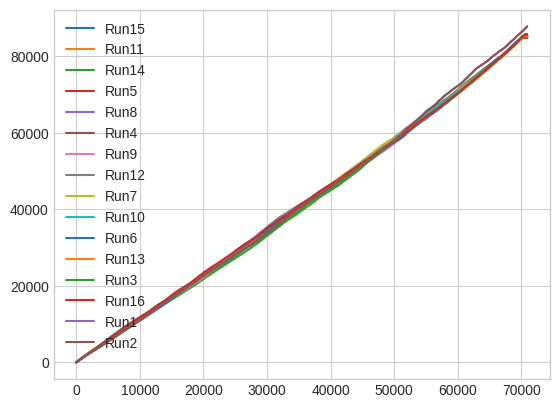

In [272]:
cumcosts.plot.line()

In [289]:
npath=fixed_con['Run11'].values.flatten().tolist()

In [327]:
remove_zeros(npath)

In [328]:
pp=np.array(npath)

In [329]:
pp.shape

(70021, 8, 2)

In [334]:
pp[0:4].sum(axis=1).mean(axis=0)

array([ 0.25, -1.25])

In [338]:
print(f'Cost before local optimization: {total_cost(pp, image):.2f}')
optimized_path = pp.copy()
difference_list = []

def optimize():
    """Optimizes optimized_path"""
    count = 0
    for i in range(len(optimized_path) - 3):
        current_cost = total_cost(optimized_path[i:i+4], image)
        new_cost = total_cost([optimized_path[i], optimized_path[i+2], optimized_path[i+1], optimized_path[i+3]], image)
        if new_cost < current_cost:
            optimized_path[i+1], optimized_path[i+2] = optimized_path[i+2].copy(), optimized_path[i+1].copy()
    #         print(i, current_cost - new_cost)
            count += 1
            difference_list.append(optimized_path[i:i+4].sum(axis=1).mean(axis=0))
    print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')

optimize()

# Let's do a second pass to be sure we haven't missed any optimization opportunity
print()
optimize()

# And a third pass
print()
optimize()

# Try another 2-opt move
print()
count = 0
for i in range(len(optimized_path) - 4):
    current_cost = total_cost([optimized_path[i], optimized_path[i+1]], image)
    current_cost += total_cost([optimized_path[i+3], optimized_path[i+4]], image)
    new_cost = total_cost([optimized_path[i], optimized_path[i+3]], image)
    new_cost += total_cost([optimized_path[i+1], optimized_path[i+4]], image)
    if new_cost < current_cost:
        optimized_path[i+1], optimized_path[i+3] = optimized_path[i+3].copy(), optimized_path[i+1].copy()
#         print(i, current_cost - new_cost)
        count += 1
        difference_list.append(optimized_path[i:i+5].sum(axis=1).mean(axis=0))
print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')

Cost before local optimization: 84783.41
Cost after local optimization: 84732.86 (after 206 2-opt moves)

Cost after local optimization: 84729.90 (after 12 2-opt moves)

Cost after local optimization: 84729.74 (after 1 2-opt moves)

Cost after local optimization: 84698.93 (after 76 2-opt moves)


In [394]:
optimize()
optimize()
for i in range(len(optimized_path) - 4):
    current_cost = total_cost([optimized_path[i], optimized_path[i+1]], image)
    current_cost += total_cost([optimized_path[i+3], optimized_path[i+4]], image)
    new_cost = total_cost([optimized_path[i], optimized_path[i+3]], image)
    new_cost += total_cost([optimized_path[i+1], optimized_path[i+4]], image)
    if new_cost < current_cost:
        optimized_path[i+1], optimized_path[i+3] = optimized_path[i+3].copy(), optimized_path[i+1].copy()
#         print(i, current_cost - new_cost)
        count += 1
        difference_list.append(optimized_path[i:i+5].sum(axis=1).mean(axis=0))
print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')

Cost after local optimization: 84690.66 (after 9 2-opt moves)
Cost after local optimization: 84690.05 (after 3 2-opt moves)
Cost after local optimization: 84690.05 (after 83 2-opt moves)


In [10]:
fixed_con = pd.read_csv('fix_runs_1-15.csv')

In [2]:
from glob import glob

In [3]:
file = glob('2023*.csv')

In [4]:
dd = pd.read_csv(file[0],header=None)

In [5]:
moreruns = pd.DataFrame()

In [6]:
runnum=17

In [13]:
for f in file:
    dd=pd.read_csv(f,header=None,names = ['Run'+str(runnum)])
    moreruns = pd.concat([moreruns,dd],axis=1)
    runnum+=1

fixed_con = pd.concat([fixed_con,moreruns],axis=1)

In [15]:
fixed_con.to_csv('runs_1-25.csv')

In [355]:
fixed_con=fixed_con.fillna(0)

In [388]:
tot_costs=pd.DataFrame()

In [381]:
fixed_con.iloc[:,16:]=fixed_con.iloc[:,16:].applymap(lambda x: literal_eval(x) if x!=0 else '0')

In [389]:
for label,cont in fixed_con.items():
    conlist= cont.values.flatten().tolist()
    remove_zeros(conlist)    
    tot_costs[label] = pd.Series(total_cost(conlist,image))

In [403]:
print(tot_costs.idxmin(axis=1),tot_costs.min(axis=1))

0    Run19
dtype: object 0    84755.272257
dtype: float64


In [5]:
xx= pd.read_csv('test1.csv')

In [ ]:
def str_to_config(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])

In [17]:
config_run=[]
for key,value in xx.items():
    for x in value:
        b= x.split(';')

        config1=[]
        for d in b:
            dd=d.split(' ')

            config1.append((int(dd[0]),int(dd[1])))
            
        config_run.append(config1)
        

In [25]:
config = [[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]]
for i in range(1,65):
    config.append([(64, i), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)])

In [26]:
config

[[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 1), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 2), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 3), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 4), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 5), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 6), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 7), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 8), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 9), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 10), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 11), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 12), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0

In [27]:
matplotlib.use("Agg")

path=config
img = np.zeros(image.shape)

pm = np.zeros(image.shape[:2])
k = 2 ** (len(path[0]) - 1) + 1


metadata=dict(title = 'Path',artist='Morin')
writer = FFMpegWriter(fps=300,metadata=metadata)
fig, ax = plt.subplots(figsize=(50, 50)) 



    
with writer.saving(fig,'path2.mp4',20):
    for i in path:


        ax.set_aspect('equal')
        ax.set_xlim(-k-1, k)
        ax.set_ylim(-k-1, k)

        ax.set_xticks(np.arange(-k, k+1))
        ax.set_yticks(np.arange(-k, k+1))
        ax.set_title(i)

        X, Y = (np.vstack([[(0, 0)], np.asarray(i).cumsum(axis=0)])[:-1].T - 0.5)
        U, V = np.asarray(i).T
        Q=ax.quiver(
            X, Y, U, V,
            angles='xy', scale_units='xy', scale=1,
            color='0.25',
            width=0.005,
            zorder=10,
        )
        point = get_position(i)
        ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
        curr_pos = cartesian_to_array(*get_position(i),image.shape)
        pm[curr_pos] = 1

        for x in range(3):
            img[:,:,x]=image[:,:,x]*pm

        ax.matshow(img, extent=[-k-1, k, -k-1, k],animated=True)
        
        writer.grab_frame()
        ax.clear()



In [64]:
for x in range(3):
    img[:,:,x]=image[:,:,x]*pm

In [58]:
image.shape

(257, 257, 3)

In [59]:
img = np.zeros(image.shape)

In [60]:
img.shape

(257, 257, 3)

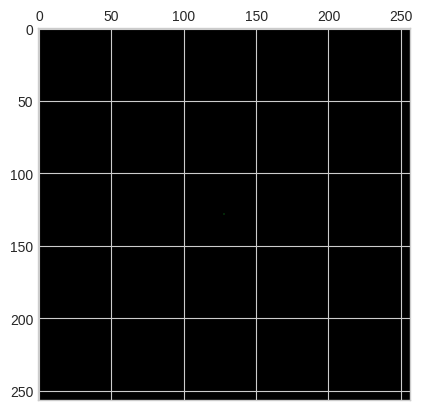

In [53]:
%matplotlib inline
plt.matshow(image)

In [ ]:
# matplotlib.use("Agg")
# path=config_run

# fig, ax = plt.subplots(figsize=(50, 50)) 
# img = image

# pm = np.zeros(image.shape[:2])
# k = 2 ** (len(path[0]) - 1) + 1



# def update(n):

#     ax.clear()
#     ax.set_xlim(-k-1, k)
#     ax.set_ylim(-k-1, k)
#     ax.set_aspect('equal')
#     ax.set_xticks(np.arange(-k, k+1))
#     ax.set_yticks(np.arange(-k, k+1))
#     X, Y = (np.vstack([[(0, 0)], np.asarray(path[n]).cumsum(axis=0)])[:-1].T - 0.5)
#     U, V = np.asarray(path[n]).T
#     Q=ax.quiver(
#         X, Y, U, V,
#         angles='xy', scale_units='xy', scale=1,
#         color='0.25',
#         width=0.005,
#         zorder=10,
#     )
#     point = get_position(path[n])
#     ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
#     curr_pos = cartesian_to_array(*get_position(path[n]),image.shape)
#     pm[curr_pos] = 1
    
#     for x in range(3):
#         img[:,:,x]=image[:,:,x]*pm

#     ax.matshow(image, extent=[-k-1, k, -k-1, k])
    
#     plt.draw()

# anim = animation.FuncAnimation(fig, update,interval=200,frames = len(path),blit=False)
# plt.close()
# anim.save('path.mp4',dpi=250,writer=FFMpegWriter(fps=60))

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [14]:
from matplotlib import rc

rc('animation',html = 'html5')

In [17]:
%xmode Verbose

Exception reporting mode: Verbose


In [ ]:
anim